# DEEP LEARNING
## Assignment 2 - Time series forecasting
In this assigment we are given a 1000 points univariate time series
where our objective is to predict the values of the following 200 points.

In [1]:
from typing import Tuple

import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend, Input, regularizers, Model
from keras.callbacks import History
from keras.engine.saving import load_model
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, LSTM
from keras.optimizers import Optimizer, Adam
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Using TensorFlow backend.


In [2]:
time_series: np.ndarray = loadmat('data/Xtrain.mat')['Xtrain']
test_series: np.ndarray = np.loadtxt('data/Xtrain.csv', delimiter=',')
test_series = np.reshape(test_series, newshape=(test_series.shape[0], 1))
data_points = time_series.shape[0]
print('Points in the dataset: {0}'.format(data_points))

Points in the dataset: 1000


Plotting of the time series

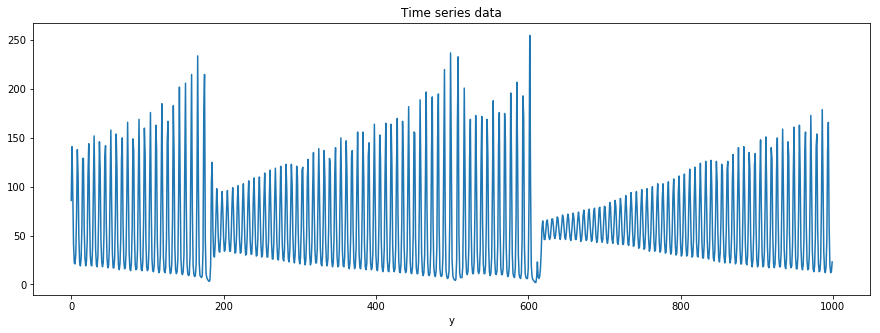

In [3]:
plt.figure(1, figsize=[15, 5])
plt.plot(time_series)
plt.xlabel('x')
plt.xlabel('y')
plt.title('Time series data')
plt.show()

First we are going to analyze the time series, to see
if we can extract valuable information about the time series that
help us regarding to the configuration of the network. For example, 
we can check the autocorrelation and the partial autocorrelation:

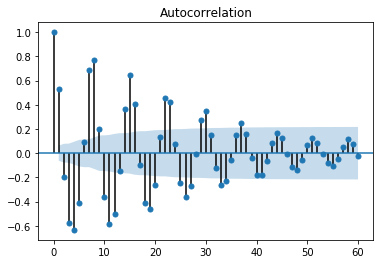

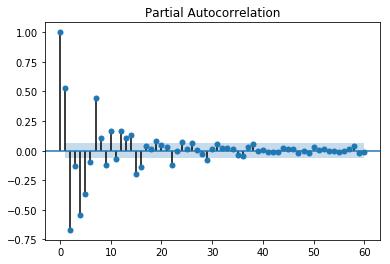

In [4]:
plot_acf(time_series, lags=60)
plt.show()
plot_pacf(time_series, lags=60)
plt.show()

We can observe in both plots, the autocorrelation and partial 
autocorrelation, that there is an influence in the value of a point
and the previous points. This influence lasts for at least 40 points,
when the influence falls under the confidence interval. 

This could give us a hint about the time windows.

### Preprocessing
In order to work with the dataset, we are going to __normalize__ it,
scaling it between [-1,1] for most of the architectures. In the LSTM architecture
better results were better using a normalization between [0, 1].

The _MinMaxScaler_ object will be used later to denormalize also.

In [5]:
min_max_scaler = preprocessing.MinMaxScaler()
time_series = min_max_scaler.fit_transform(time_series)

/home/adrigrillo/Apps/conda/envs/dl/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In order to face this problem, we are going to use a rolling windows
that will go along the time series. At each step, constant size 
features (inputs) and outputs are extracted, and therefore each series
can be a source of many input/output records.

One of the best loss measures for this kind of data is the Root
Mean Squared Error (RMSE) that we will implement in order to use it
in the Keras framework.

In [6]:
def root_mean_squared_error(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

At first, we are going to use the following structure:

- __Input__: [x(1), x(2), ..., x(time_windows)]
- __Output__: [x(time_windows + 1)]

In this way, we will predict the following step of a given input,
that will be used for the following prediction.

To process the data, we will use the following function:

In [7]:
def process_data(data: np.ndarray, x_window_size: int, y_window_size: int = 1,
                 dimensions: int = 2) -> Tuple[np.ndarray, np.ndarray]:
    """
    Method that process a time series and creates the data required to train and test the
    neural network.

    For example, for a x windows of size 3 and y, 1:

    [1, 2, 3, 4, 5] ->  [[1, 2, 3], [2, 3, 4]]; [[4], [5]]

    :param data: time series data
    :param x_window_size: number of data points that are included in the x elements
    :param y_window_size: number of data points that are included in the y elements
    :param dimensions: dimensionality of the data, 2D or 3D depending of the network
    :return: tuple with the values of x and y and the specified shapes
    """
    n_possible_elements = data.shape[0] - x_window_size - y_window_size
    if dimensions == 2:
        shape_x = (x_window_size,)
        shape_y = (y_window_size,)
    else:
        shape_x = (x_window_size, 1)
        shape_y = (y_window_size, 1)
    x = np.empty((n_possible_elements,) + shape_x)
    y = np.empty((n_possible_elements,) + shape_y)
    for i in range(n_possible_elements):
        x_end = i + x_window_size
        y_end = x_end + y_window_size
        x_element = np.reshape(data[i:x_end], newshape=shape_x)
        y_element = np.reshape(data[x_end:y_end], newshape=shape_y)
        x[i] = x_element
        y[i] = y_element
    return x, y

We will use different windows size during the assigment to compare
the effect they makes in the predictions. The dimensions argument
will be used depending on the requirements the architecture as there
will be some that use a 2D arrays, with the [examples, data], and others
will use 3D arrays, with [examples, steps, features].

As we are planning to forecast 200 steps, we are going to divide the
data in the training set and the validation set, using at least the 80%
of the data for training.

In order to plot the predicted data and the ground truth we are going to use
the following function, that will plot the both the prediction and the expected
values.

In [8]:
def plot_comparison(predicted_data: np.ndarray, real_data: np.ndarray, 
                    title: str = 'Comparison predicted and real values'):
    """
    Method to plot the predicted and the real values of the time series

    :param predicted_data: predicted data by the neural network
    :param real_data: real data that should has been predicted
    :param plot: flag to show the plot
    :param title: title of the plot
    """
    plt.figure(1, figsize=[15, 5])
    plt.plot(predicted_data, label='Predicted data')
    plt.plot(real_data, label='Real data')
    plt.xlabel('x')
    plt.xlabel('y')
    plt.title(title)
    plt.legend()
    plt.show()

### First architecture: Multi Layer Perceptron
The first architecture we are going to use is a multilayer
neural network. The definition is the following:

In [9]:
class MLP:
    def __init__(self, input_size: Tuple, optimizer: Optimizer, loss, hidden_layers: Tuple = (3, 3, 1),
                 activation: str = 'relu', output_activation: str = 'relu',
                 dropout: float = 0., batch_normalization: bool = False,
                 weight_decay_l1: float = 0., weight_decay_l2: float = 0.):
        # define model
        self.hidden_layers = hidden_layers

        # create the model
        inputs = x_data = Input(shape=input_size)
        # rest of the hidden layers if any
        for neurons in hidden_layers[:-1]:
            x_data = Dense(neurons, activation=activation,
                      kernel_regularizer=regularizers.l1_l2(l1=weight_decay_l1, l2=weight_decay_l2),
                      bias_regularizer=regularizers.l1_l2(l1=weight_decay_l1, l2=weight_decay_l2))(x_data)
            if dropout > 0.:
                x_data = Dropout(dropout)(x_data)
            if batch_normalization:
                x_data = BatchNormalization()(x_data)
        predictions = Dense(hidden_layers[-1], activation=output_activation)(x_data)
        self.model = Model(inputs=inputs, outputs=predictions)
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, inputs: np.ndarray, outputs: np.ndarray, batch_size: int = 1, epochs: int = 100) -> History:
        return self.model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs)

    def predict(self, data, number_of_steps):
        predictions = np.empty(shape=(number_of_steps,))
        data_shape = data.shape

        for i in range(predictions.shape[0]):
            predicted_value = self.model.predict(data)
            predictions[i] = predicted_value.item()
            # remove first element and add the prediction
            data = np.reshape(np.append(data[0][1:], predicted_value.item()), newshape=data_shape)
        return predictions

    def save_model(self, name):
        self.model.save('ckpt/' + name)

    def load_model(self, name):
        self.model = load_model(name)

We can see an example of this architecture with a windows of 50
steps, 2 hidden layers with three neurons using tanh as activation
function and Adam as optimizer:

In [10]:
windows = 50
x, y = process_data(time_series, x_window_size=windows, y_window_size=1, dimensions=2)

end_train = int(x.shape[0] * 0.8)
x_test = x[end_train:]
y_test = y[end_train:]
x = x[:end_train]
y = y[:end_train]

In [11]:
keras.backend.clear_session()
optimizer = Adam(0.01)
loss = root_mean_squared_error
model = MLP(input_size=(windows,), optimizer=optimizer, loss=loss,
            hidden_layers=(5, 3, 1), activation='tanh', 
            output_activation='tanh')

history = model.fit(x, y, batch_size=1, epochs=10)
val_error = model.model.evaluate(x_test, y_test)
print('The validation error using x_test and y_test is {0}'.format(val_error))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
759/759 [==============================] - 2s 3ms/step - loss: 0.0907
Epoch 2/10
759/759 [==============================] - 1s 2ms/step - loss: 0.0791
Epoch 3/10
759/759 [==============================] - 1s 2ms/step - loss: 0.0657
Epoch 4/10
759/759 [==============================] - 1s 1ms/step - loss: 0.0622
Epoch 5/10
759/759 [==============================] - 1s 1ms/step - loss: 0.0551
Epoch 6/10
759/759 [==============================] - 1s 1ms/step - loss: 0.0595
Epoch 7/10
759/759 [==============================] - 1s 1ms/step - loss: 0.0532
Epoch 8/10
759/759 [==============================] - 1s 1ms/step - loss: 0.0528
Epoch 9/10
759/759 [==============================] - 1s 1ms/step - loss: 0.0495
Epoch 10/10
190/190 [==============================] - 0s 349us/step
The validation error using x_test and y_test is 0.03589452838427142


The validation error is low, meaning that this network is already
able to predict with good accuracy the next step of a given windows.

However, when we try to predict 200 steps using the previous predictions: 

In [12]:
test = np.reshape(x_test[0], newshape=(1, windows))
predictions = model.predict(test, y_test.shape[0])

predictions = np.reshape(predictions, newshape=y_test.shape)
predictions = min_max_scaler.inverse_transform(predictions)
truth = min_max_scaler.inverse_transform(y_test)

rmse_prediction = calculate_rmse(predictions, truth)
print('The error predicting 200 steps is {0}'.format(rmse_prediction))

The error predicting 200 steps is 47.06153497325787


We can see this error is very high. We can plot to see the results
better. To do that we will define the following function:

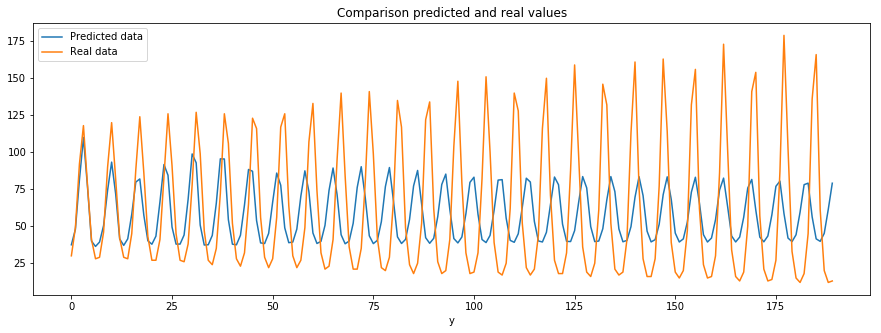

In [13]:
plot_comparison(predictions, truth)

As can be observed in the graph, the differences between the prediction and the
ground truth starts to differ in a noticeable manner after 20 steps, this is
produced due to the accumulation of errors. Moreover, this architecture will
not be capable of predicting the fluctuations that can be seen in the dataset.

Moreover, as the dataset contains certain points where there are some fluctuations,
we are going to check the behaviour of the architecture in the changes produced
near the point 600th.

In [14]:
test = np.reshape(x[500], newshape=(1, windows))
predictions = model.predict(test, 200)

y_test = np.reshape(time_series[500:700], newshape=(200, 1))
truth = min_max_scaler.inverse_transform(y_test)

predictions = np.reshape(predictions, newshape=y_test.shape)
predictions = min_max_scaler.inverse_transform(predictions)

rmse_prediction = calculate_rmse(predictions, truth)
print('The error predicting 200 steps is {0}'.format(rmse_prediction))

The error predicting 200 steps is 73.47092635076928


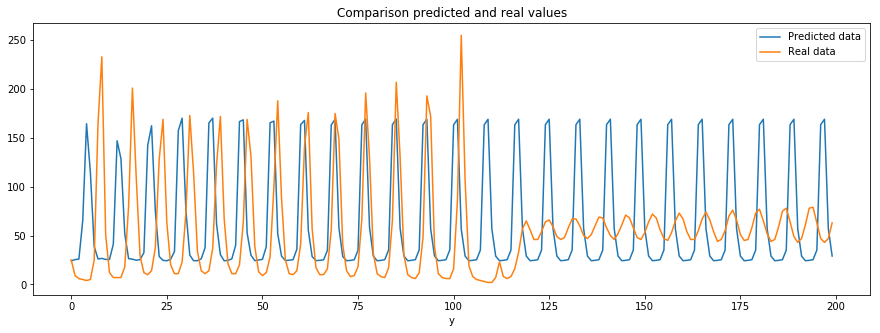

In [15]:
plot_comparison(predictions, truth)

As we can see, the neural network has not learn to handle this changes,
maintaining its predictions always. Because of these reasons we decided to move
on another architectures.

### Second architecture: CNN
In this second architecture we are going to use 1D convolutions to see if the
results improve.

In [16]:
class CNN:
    def __init__(self, input_size: Tuple, optimizer: Optimizer, loss,
                 activation: str = 'relu', output_activation: str = None):
        inputs = Input(shape=input_size)
        x_data = Conv1D(filters=64, kernel_size=16, activation=activation)(inputs)
        x_data = Conv1D(filters=32, kernel_size=8, activation=activation)(x_data)
        x_data = Conv1D(filters=16, kernel_size=4, activation=activation)(x_data)
        x_data = Flatten()(x_data)
        outputs = Dense(1, activation=output_activation)(x_data)
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, inputs: np.ndarray, outputs: np.ndarray,
            epochs: int = 100, batch_size: int = None) -> History:
        return self.model.fit(inputs, outputs, epochs=epochs, batch_size=batch_size)

    def predict(self, data, number_of_steps):
        predictions = np.empty(shape=(number_of_steps,))
        data_shape = data.shape

        for i in range(predictions.shape[0]):
            predicted_value = self.model.predict(data)
            predictions[i] = predicted_value.item()
            # remove first element and add the prediction
            data = np.reshape(np.append(data[0][1:], predicted_value.item()), newshape=data_shape)
        return predictions

    def save_model(self, name):
        self.model.save('ckpt/' + name)

    def load_model(self, name):
        self.model = load_model(name)

For this architecture we need a 3D input, using the last dimension as the
channel.

In [17]:
windows = 50
x, y = process_data(time_series, x_window_size=windows, y_window_size=1, dimensions=3)
y = y.squeeze()

end_train = int(x.shape[0] * 0.8)
x_test = x[end_train:]
y_test = y[end_train:]
x = x[:end_train]
y = y[:end_train]

In [18]:
keras.backend.clear_session()
optimizer = Adam()
loss = root_mean_squared_error
model = CNN(input_size=(windows, 1), optimizer=optimizer, loss=loss)

history = model.fit(x, y, epochs=100)
val_error = model.model.evaluate(x_test, y_test)
print('The validation error using x_test and y_test is {0}'.format(val_error))

Epoch 1/100
759/759 [==============================] - 1s 1ms/step - loss: 0.1391
Epoch 2/100
759/759 [==============================] - 0s 469us/step - loss: 0.0858
Epoch 3/100
759/759 [==============================] - 0s 436us/step - loss: 0.0657
Epoch 4/100
759/759 [==============================] - 0s 462us/step - loss: 0.0545
Epoch 5/100
759/759 [==============================] - 0s 428us/step - loss: 0.0489
Epoch 6/100
759/759 [==============================] - 0s 433us/step - loss: 0.0486
Epoch 7/100
759/759 [==============================] - 0s 471us/step - loss: 0.0432
Epoch 8/100
759/759 [==============================] - 0s 446us/step - loss: 0.0397
Epoch 9/100
759/759 [==============================] - 0s 466us/step - loss: 0.0421
Epoch 10/100
759/759 [==============================] - 0s 525us/step - loss: 0.0366
Epoch 11/100
759/759 [==============================] - 0s 477us/step - loss: 0.0313
Epoch 12/100
759/759 [==============================] - 0s 534us/step - loss

759/759 [==============================] - 0s 497us/step - loss: 0.0123
Epoch 98/100
759/759 [==============================] - 0s 623us/step - loss: 0.0121
Epoch 99/100
759/759 [==============================] - 0s 604us/step - loss: 0.0110
Epoch 100/100
190/190 [==============================] - 0s 769us/step
The validation error using x_test and y_test is 0.007035612011034238


It can be seen that the validation results are slightly better than for the MLP.
However, we have to check for the 200 steps prediction.

In [19]:
test = np.reshape(x_test[0], newshape=(1, windows, 1))
predictions = model.predict(test, y_test.shape[0])

y_test = np.reshape(y_test, newshape=(y_test.shape[0], 1))
truth = min_max_scaler.inverse_transform(y_test)

predictions = np.reshape(predictions, newshape=y_test.shape)
predictions = min_max_scaler.inverse_transform(predictions)

rmse_prediction = calculate_rmse(predictions, truth)
print('The error predicting 200 steps is {0}'.format(rmse_prediction))

The error predicting 200 steps is 53.27366338062598


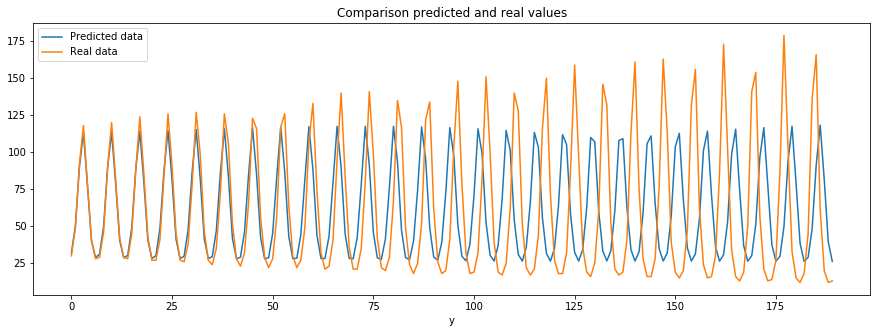

In [20]:
plot_comparison(predictions, truth)

Although we have achieved a better error than in the previous case and the plot
looks more accurate, we still can see that in the second half the phase has
shifted.

Additionally, we are going to  test the network with the change that is produced
in the range of the 600th data point.

In [21]:
test = np.reshape(x[500], newshape=(1, windows, 1))
predictions = model.predict(test, 200)

y_test = np.reshape(time_series[500:700], newshape=(200, 1))
truth = min_max_scaler.inverse_transform(y_test)

predictions = np.reshape(predictions, newshape=y_test.shape)
predictions = min_max_scaler.inverse_transform(predictions)

rmse_prediction = calculate_rmse(predictions, truth)
print('The error predicting 200 steps is {0}'.format(rmse_prediction))

The error predicting 200 steps is 70.36259996557567


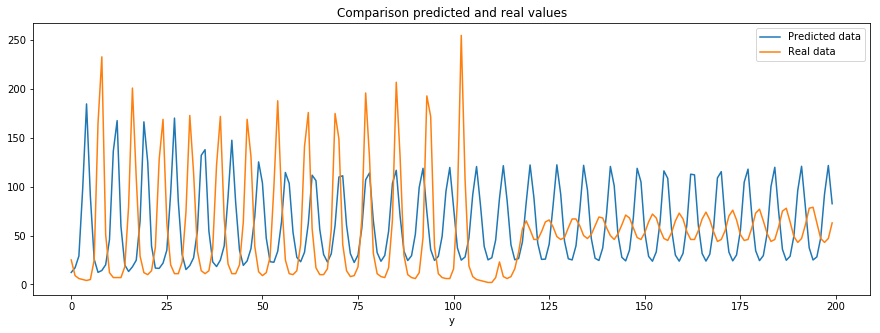

In [22]:
plot_comparison(predictions, truth)

We can see that the architecture has learn to reduce the amplitude, however is
done in a very smooth way that increases the error. Therefore, we are going to
try with an architecture with LSTMs.

### Third architecture: RNN
In this third architecture we are going to use Long short-term memory cells
to see if the results improve.

In [30]:
class RNN:
    def __init__(self, input_size: Tuple, optimizer: Optimizer, loss,
                 activation: str = 'relu', output_activation: str = None):
        inputs = Input(shape=input_size)
        x_data = LSTM(50, activation=activation, return_sequences=True)(inputs)
        x_data = LSTM(100, activation=activation, return_sequences=True)(x_data)
        x_data = LSTM(200, activation=activation)(x_data)
        x_data = Dense(6, activation=activation)(x_data)
        outputs = Dense(1, activation=output_activation)(x_data)
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, inputs: np.ndarray, outputs: np.ndarray,
            epochs: int = 100, batch_size: int = None) -> History:
        return self.model.fit(inputs, outputs, epochs=epochs, batch_size=batch_size)

    def predict(self, data, number_of_steps):
        predictions = np.empty(shape=(number_of_steps,))
        data_shape = data.shape

        for i in range(predictions.shape[0]):
            predicted_value = self.model.predict(data)
            predictions[i] = predicted_value.item()
            # remove first element and add the prediction
            data = np.reshape(np.append(data[0][0][1:], predicted_value.item()), newshape=data_shape)
        return predictions

    def save_model(self, name):
        self.model.save('ckpt/' + name)

    def load_model(self, name):
        self.model = load_model(name)

For this architecture we also need a 3D input, but the last dimension is the
one containing the data.

In [31]:
windows = 50
x, y = process_data(time_series, x_window_size=windows, y_window_size=1, dimensions=3)
x = np.reshape(x, newshape=(x.shape[0], 1, windows))
y = y.squeeze()

end_train = int(x.shape[0] * 0.8)
x_test = x[end_train:]
y_test = y[end_train:]
x = x[:end_train]
y = y[:end_train]

In [ ]:
keras.backend.clear_session()
optimizer = Adam()
loss = root_mean_squared_error
model = RNN(input_size=(1, windows), optimizer=optimizer, loss=loss)

history = model.fit(x, y, epochs=100)
val_error = model.model.evaluate(x_test, y_test)
print('The validation error using x_test and y_test is {0}'.format(val_error))

Epoch 1/100
759/759 [==============================] - 4s 5ms/step - loss: 0.1801
Epoch 2/100
759/759 [==============================] - 1s 711us/step - loss: 0.1320
Epoch 3/100
759/759 [==============================] - 1s 693us/step - loss: 0.1026
Epoch 4/100
759/759 [==============================] - 1s 727us/step - loss: 0.0737
Epoch 5/100
759/759 [==============================] - 1s 736us/step - loss: 0.0565
Epoch 6/100
759/759 [==============================] - 1s 773us/step - loss: 0.0472
Epoch 7/100
759/759 [==============================] - 1s 686us/step - loss: 0.0413
Epoch 8/100
759/759 [==============================] - 1s 775us/step - loss: 0.0371
Epoch 9/100
759/759 [==============================] - 1s 723us/step - loss: 0.0364
Epoch 10/100
759/759 [==============================] - 1s 732us/step - loss: 0.0322
Epoch 11/100
759/759 [==============================] - 1s 753us/step - loss: 0.0289
Epoch 12/100
759/759 [==============================] - 1s 760us/step - loss

It can be seen that the validation results are much better than for previous
architectures. However, we have to check for the 200 steps prediction.

In [26]:
test = np.reshape(x_test[0], newshape=(1, 1, windows))
predictions = model.predict(test, y_test.shape[0])

y_test = np.reshape(y_test, newshape=(y_test.shape[0], 1))
truth = min_max_scaler.inverse_transform(y_test)

predictions = np.reshape(predictions, newshape=y_test.shape)
predictions = min_max_scaler.inverse_transform(predictions)

rmse_prediction = calculate_rmse(predictions, truth)
print('The error predicting 200 steps is {0}'.format(rmse_prediction))

The error predicting 200 steps is 47.67023474118488


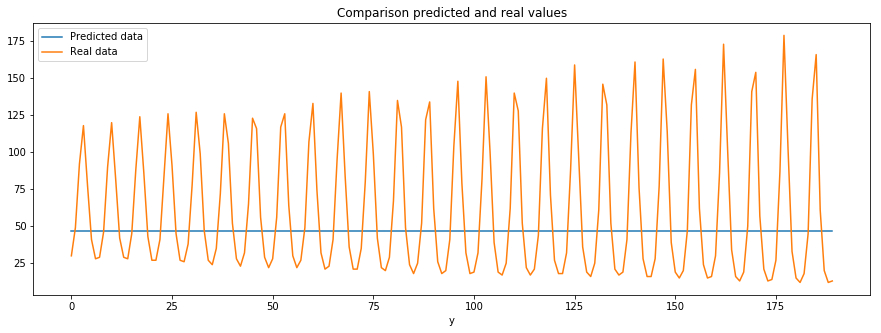

In [27]:
plot_comparison(predictions, truth)

Although we have achieved a better error than in the previous case and the plot
looks more accurate, we still can see that in the second half the phase has
shifted.

Additionally, we are going to  test the network with the change that is produced
in the range of the 600th data point.

In [28]:
test = np.reshape(x[500], newshape=(1, 1, windows))
predictions = model.predict(test, 200)

y_test = np.reshape(time_series[500:700], newshape=(200, 1))
truth = min_max_scaler.inverse_transform(y_test)

predictions = np.reshape(predictions, newshape=y_test.shape)
predictions = min_max_scaler.inverse_transform(predictions)

rmse_prediction = calculate_rmse(predictions, truth)
print('The error predicting 200 steps is {0}'.format(rmse_prediction))

The error predicting 200 steps is 49.878507387933496


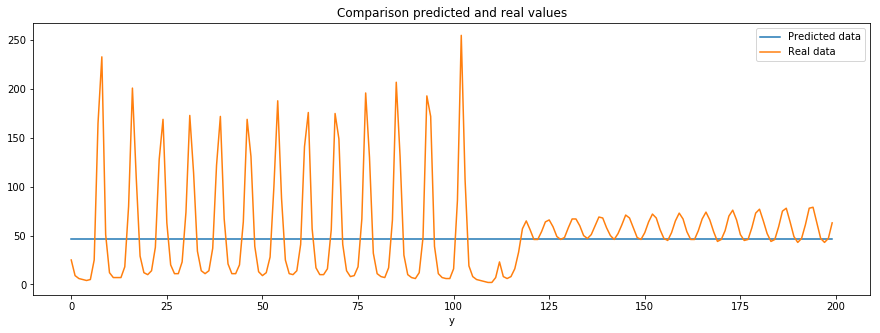

In [29]:
plot_comparison(predictions, truth)

We can see that the architecture has learn to reduce the amplitude, however is
done in a very smooth way that increases the error. Therefore, we are going to
try with an architecture with LSTMs.